In [160]:
import numpy as np 
import pandas as pd 
import yfinance as yf
from datetime import datetime
import datetime as dt

import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.linear_model import Ridge,Lasso

import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

from Utils.Portfolio_Summary import Backtest_Summary

# Investment Strategy Back-Testing

- Benchmark: SPY

In [161]:
df_price_benchmark = yf.download("SPY", start= datetime(2000,1,1), end = datetime(2022,10,1),interval='1mo').dropna()
df_price_benchmark

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-01,148.250000,148.250000,135.000000,139.562500,91.878738,1.567708e+08
2000-02-01,139.750000,144.562500,132.718750,137.437500,90.479797,1.869383e+08
2000-03-01,137.625000,155.750000,135.031250,150.375000,98.997025,2.475949e+08
2000-04-01,150.125000,153.109375,133.500000,145.093750,95.762924,2.292462e+08
2000-05-01,146.562500,148.484375,136.500000,142.812500,94.257309,1.610240e+08
...,...,...,...,...,...,...
2022-05-01,412.070007,429.660004,380.540009,412.929993,409.471893,2.418478e+09
2022-06-01,415.170013,417.440002,362.170013,377.250000,374.090698,1.958612e+09
2022-07-01,376.559998,413.029999,371.040009,411.989990,410.304535,1.437748e+09


In [162]:
df_return_benchmark = df_price_benchmark[['Close']].reset_index()
df_return_benchmark.columns = ['DATE','Benchmark Price']
df_return_benchmark.index = df_return_benchmark['DATE']
df_return_benchmark = df_return_benchmark.drop(['DATE'],axis=1)
df_return_benchmark['Benchmark Return'] = df_return_benchmark['Benchmark Price'].pct_change()
df_return_benchmark

,Benchmark Price,Benchmark Return
DATE,,
2000-01-01,139.562500,NaN
2000-02-01,137.437500,-0.015226
2000-03-01,150.375000,0.094134
2000-04-01,145.093750,-0.035121
2000-05-01,142.812500,-0.015723
...,...,...
2022-05-01,412.929993,0.002257
2022-06-01,377.250000,-0.086407
2022-07-01,411.989990,0.092087


- ETFs Sector Rotation Alpha

In [163]:
df_ridge_alpha = pd.read_excel(r'./data/Ridge Regression ETFs Alpha.xlsx',index_col='DATE')
df_lasso_alpha = pd.read_excel(r'./data/Lasso Regression ETFs Alpha.xlsx',index_col='DATE')
df_linear_alpha = pd.read_excel(r'./data/Linear Regression ETFs Alpha.xlsx',index_col='DATE')

- consrtuct long signal with top 4 alpha 

In [164]:

def Construct_Alpha_Signal_DataFrame(number_of_long_asset,df_alpha):

    df_alpha_signal = pd.DataFrame()
    for i in range(df_alpha.shape[0]):

        signal_date = df_alpha.index[i]    
        date_signal = df_alpha.iloc[i].reset_index(name='alpha').sort_values(by='alpha',ascending=False)
        trade_ticker = pd.DataFrame(date_signal['index'].to_list()[:number_of_long_asset ],index = [ "Top " + str(j+1) + " Alpha" for j in range(number_of_long_asset)], columns=[signal_date]).T
        
        df_alpha_signal  = pd.concat([df_alpha_signal, trade_ticker],axis=0)


    df_alpha_signal = df_alpha_signal.shift(1)
    return df_alpha_signal



df_ridge_alpha_signal = Construct_Alpha_Signal_DataFrame(number_of_long_asset=4,df_alpha=df_ridge_alpha)
df_lasso_alpha_signal = Construct_Alpha_Signal_DataFrame(number_of_long_asset=4,df_alpha=df_lasso_alpha)
df_linear_alpha_signal = Construct_Alpha_Signal_DataFrame(number_of_long_asset=4,df_alpha=df_linear_alpha)

df_ridge_alpha_signal

,Top 1 Alpha,Top 2 Alpha,Top 3 Alpha,Top 4 Alpha
2005-01-01,NaN,NaN,NaN,NaN
2005-02-01,XLE,XLP,XLF,XLU
2005-03-01,XLE,XLP,XLF,XLU
2005-04-01,XLE,XLP,XLF,XLU
2005-05-01,XLE,XLP,XLF,XLU
...,...,...,...,...
2022-04-01,XLF,XLY,XLI,XLU
2022-05-01,XLF,XLY,XLI,XLU
2022-06-01,XLF,XLY,XLU,XLI
2022-07-01,XLF,XLI,XLY,XLU


- ETFs Price and Return

In [165]:
dict = {
    'XLB' : 'Material',
    'XLE' : 'Energy',
    'XLF' : 'Financial',
    'XLI' : 'Industrial',
    'XLK' : 'Technology',
    'XLP' : 'Consumer Staples',
    'XLU' : 'Utility',
    'XLV' : 'Health Care',
    'XLY' : 'Consumer Discretionary',
}

dict

{'XLB': 'Material',
 'XLE': 'Energy',
 'XLF': 'Financial',
 'XLI': 'Industrial',
 'XLK': 'Technology',
 'XLP': 'Consumer Staples',
 'XLU': 'Utility',
 'XLV': 'Health Care',
 'XLY': 'Consumer Discretionary'}

In [166]:
df_etf_price = pd.read_excel(r'./data/ETFs Daily Price df.xlsx',index_col='DATE')
df_etf_price

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
DATE,,,,,,,,,
2000-01-01,13.922743,15.406697,11.868655,17.975063,38.608086,13.613623,12.359402,21.526585,20.757641
2000-02-01,12.523933,14.754468,10.598163,16.983339,42.664566,12.020637,10.857274,20.119024,19.601120
2000-03-01,13.754876,16.534883,12.487820,19.307693,46.243813,12.432620,11.954177,21.928740,22.331448
2000-04-01,13.329492,16.342661,12.654705,19.627031,41.996437,13.133813,12.831629,21.671804,21.909103
2000-05-01,12.908855,18.261688,12.937169,19.544205,37.629765,14.070637,12.803472,21.090918,20.726446
...,...,...,...,...,...,...,...,...,...
2022-05-01,84.958115,85.302902,35.097301,93.836861,139.740952,73.437263,73.243813,131.151352,153.861313
2022-06-01,72.682983,69.954254,31.119539,86.543945,126.478241,71.179016,69.105179,127.193901,136.876221
2022-07-01,77.690582,77.574211,33.533596,95.184372,143.864792,74.008575,73.452499,131.874344,162.489792


In [167]:
df_etf_return = df_etf_price.pct_change().dropna()
df_etf_return

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
DATE,,,,,,,,,
2000-02-01,-0.100469,-0.042334,-0.107046,-0.055172,0.105068,-0.117014,-0.121537,-0.065387,-0.055715
2000-03-01,0.098287,0.120670,0.178300,0.136861,0.083893,0.034273,0.101029,0.089950,0.139294
2000-04-01,-0.030926,-0.011625,0.013364,0.016539,-0.091847,0.056399,0.073401,-0.011717,-0.018913
2000-05-01,-0.031557,0.117424,0.022321,-0.004220,-0.103977,0.071329,-0.002194,-0.026804,-0.053980
2000-06-01,-0.089790,-0.059564,-0.051778,-0.041313,0.099556,0.054177,-0.041232,0.002118,-0.055907
...,...,...,...,...,...,...,...,...,...
2022-05-01,0.011761,0.160346,0.027818,-0.004625,-0.006859,-0.040829,0.043082,0.014890,-0.051203
2022-06-01,-0.144485,-0.179931,-0.113335,-0.077719,-0.094909,-0.030751,-0.056505,-0.030175,-0.110392
2022-07-01,0.068896,0.108928,0.077574,0.099839,0.137467,0.039753,0.062909,0.036798,0.187129


In [168]:
def backtesting_signal(df_etf_return,df_alpha_signal,strategy_id):

    backtest_return_list = []
    df_backtesting = pd.merge(df_etf_return,df_alpha_signal,left_index=True,right_index=True)[1:]

    for i in range(df_backtesting.shape[0]):

        long_tickers = df_backtesting[df_alpha_signal.columns.to_list()].iloc[i].reset_index(name='ticker')['ticker'].to_list()
        long_returns = df_backtesting[long_tickers].iloc[i].reset_index(name='returns')['returns'].values

        index = df_backtesting.index[i]
        portfolio_return = np.mean(long_returns)
        backtest_return_list.append(portfolio_return)

    df_backtesting[str(strategy_id)] = backtest_return_list
    df_backtesting = df_backtesting.drop(df_alpha_signal.columns,axis=1)
    
    return df_backtesting

df_backtesting_reseult = backtesting_signal(df_etf_return,df_ridge_alpha_signal,strategy_id='Ridge Alpha Strategy Return')
df_backtesting_reseult = backtesting_signal(df_backtesting_reseult,df_lasso_alpha_signal,strategy_id='Lasso Alpha Strategy Return')
df_backtesting_reseult = backtesting_signal(df_backtesting_reseult,df_linear_alpha_signal,strategy_id='Linear Alpha Strategy Return')
df_backtesting_reseult 

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,Ridge Alpha Strategy Return,Lasso Alpha Strategy Return,Linear Alpha Strategy Return
2005-04-01,-0.068093,-0.050968,0.007095,-0.033102,-0.035276,-0.006314,0.038700,0.038359,-0.062294,-0.002872,-0.018317,-0.002872
2005-05-01,-0.006427,0.027867,0.029535,0.031719,0.069422,0.023266,-0.000666,0.012621,0.061836,0.020001,0.012577,0.020001
2005-06-01,-0.024793,0.066459,0.006490,-0.028761,-0.012885,-0.024024,0.050949,-0.008310,-0.005763,0.024968,0.010598,0.024968
2005-07-01,0.060437,0.074214,0.021639,0.040707,0.056727,0.037062,0.030850,0.025675,0.058285,0.038094,0.053644,0.038094
2005-08-01,-0.041899,0.063866,-0.016372,-0.023606,-0.009500,-0.017462,0.006508,-0.003467,-0.032910,0.009135,-0.001109,0.009135
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,-0.031762,-0.007472,-0.095902,-0.073058,-0.108530,0.027700,-0.036581,-0.045942,-0.118215,-0.080939,-0.077317,-0.080939
2022-05-01,0.011761,0.160346,0.027818,-0.004625,-0.006859,-0.040829,0.043082,0.014890,-0.051203,0.003768,0.002571,0.003768
2022-06-01,-0.144485,-0.179931,-0.113335,-0.077719,-0.094909,-0.030751,-0.056505,-0.030175,-0.110392,-0.089488,-0.053085,-0.089488
2022-07-01,0.068896,0.108928,0.077574,0.099839,0.137467,0.039753,0.062909,0.036798,0.187129,0.106863,0.069231,0.106863


In [169]:
df_backtesting_reseult['All ETFs Equal Weighted Return'] = df_backtesting_reseult[df_etf_return.columns].mean(axis=1)
df_backtesting = pd.merge(df_backtesting_reseult,df_return_benchmark,left_index=True,right_index=True)
df_backtesting

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,Ridge Alpha Strategy Return,Lasso Alpha Strategy Return,Linear Alpha Strategy Return,All ETFs Equal Weighted Return,Benchmark Price,Benchmark Return
2005-04-01,-0.068093,-0.050968,0.007095,-0.033102,-0.035276,-0.006314,0.038700,0.038359,-0.062294,-0.002872,-0.018317,-0.002872,-0.019099,115.750000,-0.018735
2005-05-01,-0.006427,0.027867,0.029535,0.031719,0.069422,0.023266,-0.000666,0.012621,0.061836,0.020001,0.012577,0.020001,0.027686,119.480003,0.032225
2005-06-01,-0.024793,0.066459,0.006490,-0.028761,-0.012885,-0.024024,0.050949,-0.008310,-0.005763,0.024968,0.010598,0.024968,0.002151,119.180000,-0.002511
2005-07-01,0.060437,0.074214,0.021639,0.040707,0.056727,0.037062,0.030850,0.025675,0.058285,0.038094,0.053644,0.038094,0.045066,123.739998,0.038261
2005-08-01,-0.041899,0.063866,-0.016372,-0.023606,-0.009500,-0.017462,0.006508,-0.003467,-0.032910,0.009135,-0.001109,0.009135,-0.008316,122.580002,-0.009374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,-0.031762,-0.007472,-0.095902,-0.073058,-0.108530,0.027700,-0.036581,-0.045942,-0.118215,-0.080939,-0.077317,-0.080939,-0.054418,412.000000,-0.087769
2022-05-01,0.011761,0.160346,0.027818,-0.004625,-0.006859,-0.040829,0.043082,0.014890,-0.051203,0.003768,0.002571,0.003768,0.017153,412.929993,0.002257
2022-06-01,-0.144485,-0.179931,-0.113335,-0.077719,-0.094909,-0.030751,-0.056505,-0.030175,-0.110392,-0.089488,-0.053085,-0.089488,-0.093134,377.250000,-0.086407
2022-07-01,0.068896,0.108928,0.077574,0.099839,0.137467,0.039753,0.062909,0.036798,0.187129,0.106863,0.069231,0.106863,0.091032,411.989990,0.092087


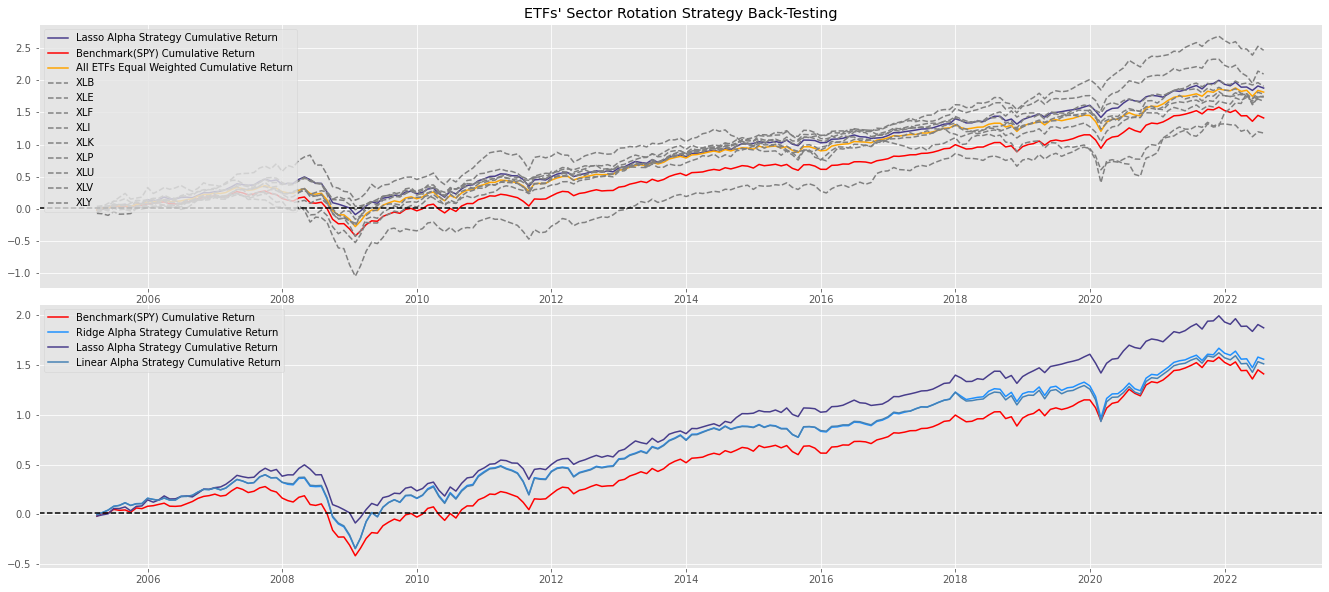

In [170]:
plt.subplots(figsize=(23,10))
ax1 = plt.subplot2grid((6,1),(0,0),rowspan=3,colspan=1)
ax1.set_title("ETFs' Sector Rotation Strategy Back-Testing")

ax1.plot(df_backtesting.index, df_backtesting['Lasso Alpha Strategy Return'].cumsum(),label='Lasso Alpha Strategy Cumulative Return',color='darkslateblue')
ax1.plot(df_backtesting.index, df_backtesting['Benchmark Return'].cumsum(),label='Benchmark(SPY) Cumulative Return',color='red')
ax1.plot(df_backtesting.index, df_backtesting['All ETFs Equal Weighted Return'].cumsum(),label='All ETFs Equal Weighted Cumulative Return',color='orange')
for i in range(df_etf_return.shape[1]):
    ax1.plot(df_backtesting.index , df_backtesting[df_etf_return.columns[i]].cumsum() ,label=str(df_etf_return.columns[i]),linestyle='--',color='gray')
ax1.axhline(0.01 , linestyle='--' , color='black')
ax1.legend(loc='upper left')

ax2 = plt.subplot2grid((6,1),(3,0),rowspan=3,colspan=1)
ax2.plot(df_backtesting.index, df_backtesting['Benchmark Return'].cumsum(),label='Benchmark(SPY) Cumulative Return',color='red')
ax2.plot(df_backtesting.index, df_backtesting['Ridge Alpha Strategy Return'].cumsum(),label='Ridge Alpha Strategy Cumulative Return',color='dodgerblue')
ax2.plot(df_backtesting.index, df_backtesting['Lasso Alpha Strategy Return'].cumsum(),label='Lasso Alpha Strategy Cumulative Return',color='darkslateblue')
ax2.plot(df_backtesting.index, df_backtesting['Linear Alpha Strategy Return'].cumsum(),label='Linear Alpha Strategy Cumulative Return',color='steelblue')
ax2.axhline(0.01 , linestyle='--' , color='black')
ax2.legend()
plt.show()

In [171]:
start_date = df_backtesting.index[0]
end_date = df_backtesting.index[-1]

benchmark_backtest = Backtest_Summary(start_date = start_date, end_date = end_date, returns = df_backtesting['Benchmark Return'].values,name='Benchmark Performance',freq='M')
etf_weighted_backtest = Backtest_Summary(start_date = start_date, end_date = end_date, returns = df_backtesting['All ETFs Equal Weighted Return'].values,name='ETFs Equal Weighted',freq='M')
lasso_alpha_backtest = Backtest_Summary(start_date = start_date, end_date = end_date, returns = df_backtesting['Lasso Alpha Strategy Return'].values,name='Lasso Alpha Strategy',freq='M')
ridge_alpha_backtest = Backtest_Summary(start_date = start_date, end_date = end_date, returns = df_backtesting['Ridge Alpha Strategy Return'].values,name='Ridge Alpha Strategy',freq='M')
linear_alpha_backtest = Backtest_Summary(start_date = start_date, end_date = end_date, returns = df_backtesting['Linear Alpha Strategy Return'].values,name='Linear Alpha Strategy',freq='M')
Backtsting_Result = pd.concat([benchmark_backtest,etf_weighted_backtest,linear_alpha_backtest,lasso_alpha_backtest,ridge_alpha_backtest],axis=1)

Backtsting_Result

,Benchmark Performance,ETFs Equal Weighted,Linear Alpha Strategy,Lasso Alpha Strategy,Ridge Alpha Strategy
Start Date,2005-04-01,2005-04-01,2005-04-01,2005-04-01,2005-04-01
End Date,2022-08-01,2022-08-01,2022-08-01,2022-08-01,2022-08-01
Total Periods,208 Months,208 Months,208 Months,208 Months,208 Months
-,-,-,-,-,-
Annual Return,0.08,0.1,0.09,0.11,0.09
Anuual Volitiliy,0.15,0.15,0.18,0.15,0.18
Cumulative Return,1.41,1.81,1.51,1.87,1.56
Sharpe Ratio,0.54,0.69,0.47,0.74,0.49
Calmar Ratio,0.12,0.16,0.12,0.18,0.12
Maximum Drawdown,0.7,0.64,0.74,0.58,0.74


# Investment Case Study - 10,000 USD Investment Scanerio with the ETFs Sector Rotation Strategy

In [172]:
def Real_Investment_Alpha_BackTesing(initial_investment_value,df_etf_price,df_alpha_signal):

    # 
    df_backtesting = pd.merge(df_etf_price,df_alpha_signal,left_index=True,right_index=True)[1:]
    initial_investment_cost = initial_investment_value

    real_investment_datafrmae = pd.DataFrame()
    settle_date_list = []
    portfolio_value_list = []
    portfolio_total_value_list = []
    remain_cash_list = []
    pnl_list = []


    for i in range(df_backtesting.shape[0]):

        try:
            long_tickers = df_backtesting[df_alpha_signal.columns.to_list()].iloc[i].reset_index(name='ticker')['ticker'].to_list()
            long_price = df_backtesting[long_tickers].iloc[i].reset_index(name='close')['close'].to_list()
            long_price_t1 = df_backtesting[long_tickers].iloc[i+1].reset_index(name='close')['close'].to_list()

            #
            number_of_holdings = [ int( (initial_investment_value/df_alpha_signal.shape[1])/price) for price in long_price ] 
            portfolio_value = np.array(number_of_holdings) @ np.array(long_price)
            remain_cash = initial_investment_value - portfolio_value

            #
            portfolio_value_t1 = np.array(number_of_holdings) @ np.array(long_price_t1)
            portfolio_total_value = portfolio_value_t1 + remain_cash

            #
            settle_date = df_backtesting.index[i+1]
            initial_investment_value = portfolio_total_value
            portfolio_pnl = portfolio_total_value - initial_investment_cost

            settle_date_list.append(settle_date)
            portfolio_value_list.append( portfolio_value )
            remain_cash_list.append( remain_cash )
            portfolio_total_value_list.append(portfolio_total_value)
            pnl_list.append(portfolio_pnl)

        except:
            pass

    real_investment_datafrmae.index = settle_date_list
    real_investment_datafrmae['Portfolio Value(T-1)'] = portfolio_value_list
    real_investment_datafrmae['Cash Position(T-1)'] = remain_cash_list
    real_investment_datafrmae['Portfolio Total Value(T)'] = portfolio_total_value_list
    real_investment_datafrmae['Cost'] = initial_investment_cost
    real_investment_datafrmae['PnL'] = pnl_list

    return real_investment_datafrmae


alpha_real_investment_df = Real_Investment_Alpha_BackTesing(initial_investment_value=10000,df_etf_price=df_etf_price,df_alpha_signal=df_lasso_alpha_signal)
alpha_real_investment_df

,Portfolio Value(T-1),Cash Position(T-1),Portfolio Total Value(T),Cost,PnL
2005-03-01,9946.939451,53.060549,9729.985779,10000,-270.014221
2005-04-01,9698.605408,31.380371,9307.967535,10000,-692.032465
2005-05-01,9256.800100,51.167435,9424.324299,10000,-575.675701
2005-06-01,9403.134789,21.189510,9656.879185,10000,-343.120815
2005-07-01,9592.783272,64.095913,10171.188465,10000,171.188465
...,...,...,...,...,...
2022-04-01,52488.462975,406.948290,48843.859392,10000,38843.859392
2022-05-01,48558.257111,285.602282,48842.329233,10000,38842.329233
2022-06-01,48703.597137,138.732096,46258.548220,10000,36258.548220
2022-07-01,46028.536499,230.011721,49446.355349,10000,39446.355349


- Buy and Hold All ETFs Strategy

In [173]:
initial_investment_value = 10000
initial_investment_cost = initial_investment_value

df_backtesting = df_etf_price[df_etf_price.index >= dt.datetime(2005,2,1)]
long_price = df_backtesting.iloc[0].reset_index(name='close')['close'].to_list()
number_of_holdings = [ int( (initial_investment_value/df_backtesting.shape[1])/price) for price in long_price ] 
portfolio_value = np.array(number_of_holdings) @ np.array(long_price)

remain_cash = initial_investment_value - portfolio_value
portfolio_total_value = portfolio_value + remain_cash
portfolio_pnl = portfolio_total_value - initial_investment_cost

real_investment_dataframe = pd.DataFrame()
settle_date_list = [df_backtesting.index[0]]
portfolio_value_list = [portfolio_value]
portfolio_total_value_list = [portfolio_total_value]
remain_cash_list = [remain_cash]
pnl_list = [portfolio_pnl]


for i in range(1,df_backtesting.shape[0]):

    settle_date = df_backtesting.index[i]
    long_price = df_backtesting.iloc[i].reset_index(name='close')['close'].to_list()

    portfolio_value = np.array(number_of_holdings) @ np.array(long_price)
    portfolio_total_value = portfolio_value + remain_cash
    portfolio_pnl = portfolio_total_value - initial_investment_cost

    settle_date_list.append(settle_date)
    portfolio_value_list.append( portfolio_value )
    remain_cash_list.append( remain_cash )
    portfolio_total_value_list.append(portfolio_total_value)
    pnl_list.append(portfolio_pnl)

real_investment_dataframe.index = settle_date_list
real_investment_dataframe['Portfolio Value(T-1)'] = portfolio_value_list
real_investment_dataframe['Cash Position(T-1)'] = remain_cash_list
real_investment_dataframe['Portfolio Total Value(T)'] = portfolio_total_value_list
real_investment_dataframe['Cost'] = initial_investment_cost
real_investment_dataframe['PnL'] = pnl_list

real_investment_dataframe = real_investment_dataframe[1:-1]
real_investment_dataframe

,Portfolio Value(T-1),Cash Position(T-1),Portfolio Total Value(T),Cost,PnL
2005-03-01,9746.302897,87.847953,9834.150850,10000,-165.849150
2005-04-01,9561.448819,87.847953,9649.296772,10000,-350.703228
2005-05-01,9821.814528,87.847953,9909.662481,10000,-90.337519
2005-06-01,9845.063458,87.847953,9932.911411,10000,-67.088589
2005-07-01,10285.256505,87.847953,10373.104458,10000,373.104458
...,...,...,...,...,...
2022-04-01,48084.281273,87.847953,48172.129226,10000,38172.129226
2022-05-01,48327.002991,87.847953,48414.850944,10000,38414.850944
2022-06-01,44130.750317,87.847953,44218.598269,10000,34218.598269
2022-07-01,48325.994186,87.847953,48413.842139,10000,38413.842139


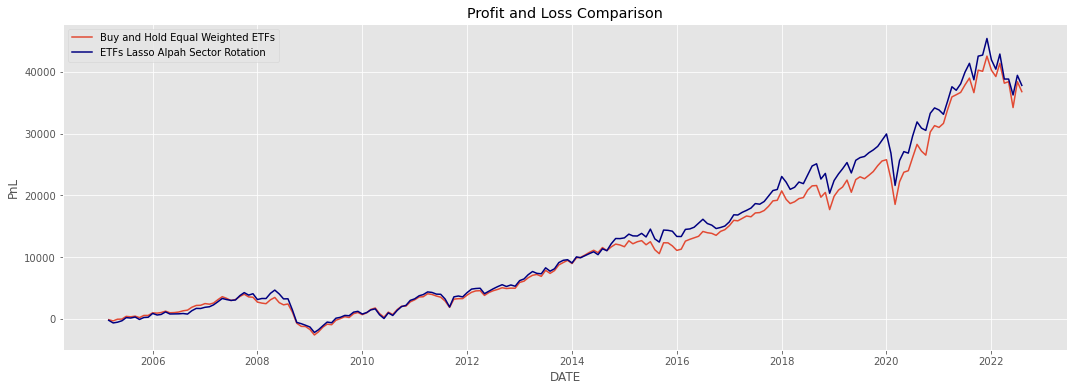

In [174]:
fig, ax = plt.subplots(figsize=(18,6))
ax.set_title('Profit and Loss Comparison')
ax.plot(real_investment_dataframe.index ,real_investment_dataframe['PnL'],label='Buy and Hold Equal Weighted ETFs')
ax.plot(alpha_real_investment_df.index ,alpha_real_investment_df['PnL'],label='ETFs Lasso Alpah Sector Rotation',color='navy')
ax.set_xlabel('DATE')
ax.set_ylabel('PnL')
ax.legend()
plt.show()